<a href="https://colab.research.google.com/github/deepanshudaw/Adversarial-Attacks/blob/master/Targeted_Attack_on_MNIST(Pytorch%2CKeras%2Ctf).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Drive Merge

In [0]:
from google.colab import drive
drive.mount('/content/drive')                                                   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Imports

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

#LeNet Pretrained model

In [0]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "/content/drive/My Drive/MNIST_pretrained_model/lenet_mnist_model.pth"
use_cuda=True

In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

#FGSM Attack

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
  

AdvImage takes epsilon as the input and gives 10000 adversarial images by attacking the test data. It also gives all the true labels of the adversarial images in the form of a list.

In [0]:
def AdvImage(epsilon):
    advarray=[]
    label=[]
    images=[]
    i=0
    print("!Attack Initiated!")
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)
        
        label.insert(i,target.item())
        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        i=i+1
        images.insert(i,data)
        advarray.insert(i,perturbed_data)
    print("!Attack Successful!")
    return advarray,label,images

In [0]:
#a,label,normalimg=AdvImage(0.1)
a_2,label_2,image_2=AdvImage(0.2)

10000


#Keras Model

This is our model on which we will be testing the adversarial images

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
mnist = keras.datasets.mnist
(train_images, train_label), (test_images, test_label) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

In [0]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model1.fit(train_images, train_label, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.2547 - acc: 0.9263
Epoch 2/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.1137 - acc: 0.9673
Epoch 3/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0791 - acc: 0.9763
Epoch 4/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0595 - acc: 0.9822
Epoch 5/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0454 - acc: 0.9862


In [0]:
test_loss, test_acc = model1.evaluate(test_images, test_label)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 48us/sample - loss: 0.0842 - acc: 0.9742
Test accuracy: 0.9742


Testing the model on normal images

In [0]:
def plot(k):
  ar=np.empty(10)
  for i in range(10):
    ar[i]=model1.predict(test_images[k:k+1])[0][i]
  mx=0
  max_index=0
  for i in range(10):
    mx=max(mx,ar[i])
    if(mx==ar[i]):
      max_index=i
  print("The predicted digit is",max_index)
  index = np.arange(10)
  plt.bar(index,ar,tick_label=index)
  plt.show
def getimage_true(k):
  print("True Value is:", test_label[k])  
  plt.imshow(test_images[k], cmap='Greys')
  plt.show()

Index no: 4692
True Value is: 9


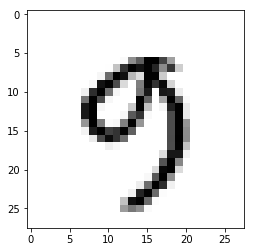

The predicted digit is 9


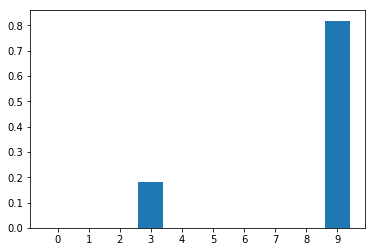

In [0]:
k=random.randint(0,9999) 
#k=3460
print("Index no:",k)
getimage_true(k)
plot(k)

#Testing model on adv example

In [0]:
epsilon=0.2
start = time.clock()
a_2,label_2,image_2=AdvImage(epsilon)
print ('Time elapsed: ',float(time.clock() - start),'s')

!Attack Initiated!
!Attack Successful!
Time elapsed:  17.54927500000008 s


In [0]:
def realimage(g): 
  print("Actual Image was:")
  plt.imshow(image_2[g][0].cpu().detach().reshape(28,28), cmap='Greys')
  plt.show()

def plotforeg(g):
  ar=np.empty(10)
  for i in range(10):
    ar[i]=model1.predict(a_2[g][0].cpu().detach())[:,i]
  mx=0
  max_index=0
  for i in range(10):
    mx=max(mx,ar[i])
    if(mx==ar[i]):
      max_index=i
  print("Predicted element for  adversarial image:",max_index)
  index = np.arange(10)
  plt.bar(index,ar,tick_label=index)
  plt.show
def getimage(g):
  print("True Value is:", label_2[g])  
  plt.imshow(a_2[g][0].cpu().detach().reshape(28,28), cmap='Greys')
  plt.show()
def getlabel(g):
  ar=np.empty(10)
  for i in range(10):
    ar[i]=model1.predict(image_2[g][0].cpu().detach())[:,i]
  mx=0
  max_index=0
  for i in range(10):
      mx=max(mx,ar[i])
      if(mx==ar[i]):
        max_index=i
  print("Predicted element for normal image:      ",max_index)

In [0]:
epsilon

0.2

k:  5425
True Value is: 2


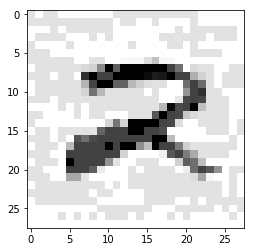

Actual Image was:


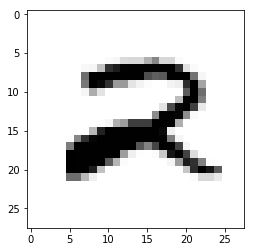

Predicted element for  adversarial image: 3
Predicted element for normal image:       2


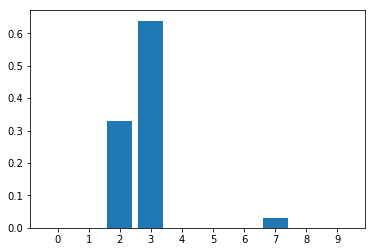

In [0]:
k=random.randint(0,9999)
print("k: ",k)
getimage(k)
realimage(k)
plotforeg(k)
getlabel(k)

In [0]:
def accuracy(epsilon):
  a_2,label_2,image_2=AdvImage(epsilon)
  predicted=[]
  acc=0
  for g in range(10000):
    ar=np.empty(10)
    for i in range(10):
      ar[i]=model1.predict(a_2[g][0].cpu().detach())[:,i]
    mx=0
    max_index=0
    for i in range(10):
        mx=max(mx,ar[i])
        if(mx==ar[i]):
          max_index=i
    #predicted.insert(g,max_index)
    if max_index==label_2[g]:
      acc=acc+1
  return acc/10000

In [0]:
e=np.empty(4)
for i in [0.1,0.15,0.2,0.3]:
  print(accuracy(i))

!Attack Initiated!
!Attack Successful!
0.8653
!Attack Initiated!
!Attack Successful!
0.6557
!Attack Initiated!
!Attack Successful!
0.4687
!Attack Initiated!
!Attack Successful!
0.2066


#Model2

This is our model on which we will be testing the adversarial images

In [0]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model2.fit(train_images, train_label, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.4693 - acc: 0.8767
Epoch 2/5
60000/60000 [==============================] - 4s 73us/sample - loss: 0.3042 - acc: 0.9158
Epoch 3/5
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2835 - acc: 0.9204
Epoch 4/5
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2732 - acc: 0.9233
Epoch 5/5
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2667 - acc: 0.9251


In [0]:
test_loss, test_acc = model2.evaluate(test_images, test_label)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 47us/sample - loss: 0.2658 - acc: 0.9269
Test accuracy: 0.9269


Testing the model on normal images

In [0]:
def plot2(k):
  ar=np.empty(10)
  for i in range(10):
    ar[i]=model2.predict(test_images[k:k+1])[0][i]
  mx=0
  max_index=0
  for i in range(10):
    mx=max(mx,ar[i])
    if(mx==ar[i]):
      max_index=i
  print("The predicted digit is",max_index)
  index = np.arange(10)
  plt.bar(index,ar,tick_label=index)
  plt.show
def getimage2(k):
  print("True Value is:", test_label[k])  
  plt.imshow(test_images[k], cmap='Greys')
  plt.show()

Index no: 9390
True Value is: 3


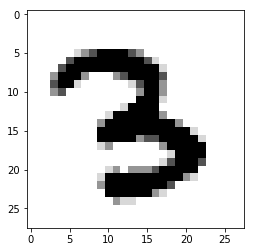

The predicted digit is 3


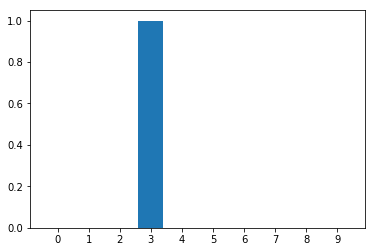

In [0]:
k=random.randint(0,9999) 
#k=3460
print("Index no:",k)
getimage2(k)
plot2(k)

In [0]:
def realimage2(g): 
  print("Actual Image was:")
  plt.imshow(image_2[g][0].cpu().detach().reshape(28,28), cmap='Greys')
  plt.show()

def plotforeg2(g):
  ar=np.empty(10)
  for i in range(10):
    ar[i]=model2.predict(a_2[g][0].cpu().detach())[:,i]
  mx=0
  max_index=0
  for i in range(10):
    mx=max(mx,ar[i])
    if(mx==ar[i]):
      max_index=i
  print("Predicted element for  adversarial image:",max_index)
  index = np.arange(10)
  plt.bar(index,ar,tick_label=index)
  plt.show
def getimage2(g):
  print("True Value is:", label_2[g])  
  plt.imshow(a_2[g][0].cpu().detach().reshape(28,28), cmap='Greys')
  plt.show()
def getlabel2(g):
  ar=np.empty(10)
  for i in range(10):
    ar[i]=model2.predict(image_2[g][0].cpu().detach())[:,i]
  mx=0
  max_index=0
  for i in range(10):
      mx=max(mx,ar[i])
      if(mx==ar[i]):
        max_index=i
  print("Predicted element for normal image:      ",max_index)

k:  1277
True Value is: 1


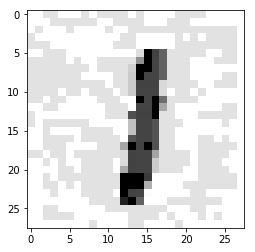

Actual Image was:


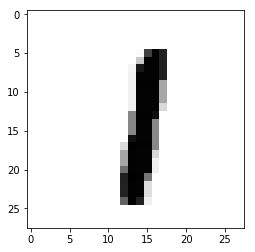

Predicted element for  adversarial image: 2
Predicted element for normal image:       1


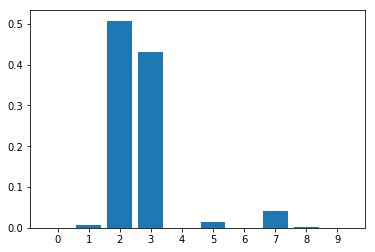

In [0]:
k=random.randint(0,9999)
print("k: ",k)
getimage2(k)
realimage2(k)
plotforeg2(k)
getlabel2(k)

In [0]:
def accuracy2(epsilon):
  a_2,label_2,image_2=AdvImage(epsilon)
  predicted=[]
  acc=0
  for g in range(10000):
    ar=np.empty(10)
    for i in range(10):
      ar[i]=model2.predict(a_2[g][0].cpu().detach())[:,i]
    mx=0
    max_index=0
    for i in range(10):
        mx=max(mx,ar[i])
        if(mx==ar[i]):
          max_index=i
    #predicted.insert(g,max_index)
    if max_index==label_2[g]:
      acc=acc+1
  return acc/10000

In [0]:
print(accuracy2(0.1))

!Attack Initiated!
!Attack Successful!
0.692


In [0]:
print(accuracy2(0.15))
print(accuracy2(0.2))
print(accuracy2(0.3))

!Attack Initiated!
!Attack Successful!
0.426
!Attack Initiated!
!Attack Successful!
0.2852
!Attack Initiated!
!Attack Successful!
0.1862
